<a href="https://colab.research.google.com/github/talhaanwarch/Profiling-Hate-Speech-Spreaders-on-Twitter/blob/main/en_ag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9e1e8645-7bac-544b-fbd9-9ed4776ccc99)


#install pacakges

In [2]:
%%capture
!python3 -m pip install -U pip
!python3 -m pip install -U setuptools wheel
!python3 -m pip install -U "mxnet_cu110<2.0.0"
!python3 -m pip install autogluon

# download data

In [3]:
import os
if os.path.isdir('/content/Profiling-Hate-Speech-Spreaders-on-Twitter') is False:
    !git clone https://github.com/talhaanwarch/Profiling-Hate-Speech-Spreaders-on-Twitter.git

In [4]:
%%capture 
if os.path.isdir('train') is False:
  !unzip /content/Profiling-Hate-Speech-Spreaders-on-Twitter/data/train.zip
if os.path.isdir('test') is False:
  !unzip /content/Profiling-Hate-Speech-Spreaders-on-Twitter/data/test.zip

# prepare data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df=pd.read_csv('train/en/truth.txt',sep=':::',header=None,engine='python')
df.columns=['id','label']

In [6]:
df.label.value_counts()

1    100
0    100
Name: label, dtype: int64

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
stop = stopwords.words('english')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def preprocessing(text):
    text=text.str.replace('\d+', '')
    text=text.str.replace('RT','')
    text=text.str.replace('#USER#','')
    text=text.str.replace('#URL#','')
    text= text.str.lower()
    text = text.str.replace('[^\w\s]','')
    text = text.apply(lambda x : [lemmatizer.lemmatize(y) for y in w_tokenizer.tokenize(x)])
    text = text.apply(lambda x: [item for item in x if item not in stop])
    text = text.apply(lambda x : " ".join(x))
    return text

In [9]:
df.id='train/en/'+df.id.astype(str)+'.xml'
df.head()

,id,label
0,train/en/639b8e5e6a527d494c85d8f5704b1a01.xml,0
1,train/en/f2b1fc84c500c38a93522efbd422b559.xml,0
2,train/en/10b2d013382e1fb3c9414ea28329f258.xml,0
3,train/en/26644d1348fc1122e8c5ef45d6bc84fa.xml,0
4,train/en/4d4c5dcbfe38d0d33a0d1b1419952ca8.xml,0


In [10]:
len(df)

200

In [11]:
import xml.etree.ElementTree as ET
def reader(df,ground=True):
  data=[]
  for x in df.iterrows():
      
      tree = ET.parse(x[1].id)
      root = tree.getroot()
      text=[x.text for x in root[0]]
      if ground:
        label=[x[1].label]*len(text)
        data.append(pd.DataFrame(zip(text,label),columns=['text','label']))
      else:
        data.append(pd.DataFrame(text,columns=['text']))
  return data

In [12]:
data=reader(df)

In [13]:
data[0].head()

,text,label
0,RT #USER#: Funny how “15 days to slow the spre...,0
1,RT #USER#: Why did Minneapolis just give Georg...,0
2,"RT #USER#: To be fair, he has done a lot of un...",0
3,RT #USER#: President Trump got us the #HASHTAG...,0
4,RT #USER#: Is the case against former officer ...,0


In [14]:
from sklearn.model_selection import train_test_split
trainx,valx=train_test_split(data,test_size=0.1,shuffle=True)
trainx,testx=train_test_split(trainx,test_size=0.1,shuffle=True)

In [15]:
train=pd.concat(trainx)
val=pd.concat(valx)
test=pd.concat(testx)

In [16]:
train.label.value_counts()

1    16400
0    16000
Name: label, dtype: int64

In [17]:
val.label.value_counts()

0    2600
1    1400
Name: label, dtype: int64

In [18]:
test.label.value_counts()

1    2200
0    1400
Name: label, dtype: int64

In [19]:
train.text=preprocessing(train.text)
val.text=preprocessing(val.text)
test.text=preprocessing(test.text)

In [20]:
len(train),len(val),len(test)

(32400, 4000, 3600)

In [21]:
train = train.sample(frac=1).reset_index(drop=True)
val = val.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)


In [22]:
train_text=train.text
train_label=train.label
val_text=val.text
val_label=val.label
test_text=test.text
test_label=test.label

In [23]:
train.head()

,text,label
0,objective damn autocorrect,0
1,second amendment ha nothing hunting,0
2,new york cityyyyy,0
3,somebody said think crazy wait till mf turn st...,1
4,think stucky stuck stupid,1


# classify data

INFO:root:NumPy-shape semantics has been activated in your code. This is required for creating and manipulating scalar and zero-size tensors, which were not supported in MXNet before, as in the official NumPy library. Please DO NOT manually deactivate this semantics while using `mxnet.numpy` and `mxnet.numpy_extension` modules.
INFO:autogluon.text.text_prediction.mx.models:The GluonNLP V0 backend is used. We will use 2 cpus and 1 gpus to train each trial.


All Logs will be saved to /content/AutogluonModels/ag-20210601_105826/task0/training.log


INFO:root:Fitting and transforming the train data...
INFO:root:Done! Preprocessor saved to /content/AutogluonModels/ag-20210601_105826/task0/preprocessor.pkl
INFO:root:Process dev set...
INFO:root:Done!
INFO:root:Max length for chunking text: 64, Stochastic chunk: Train-False/Test-False, Test #repeat: 1.
INFO:root:#Total Params/Fixed Params=108990466/0
Level 15:root:Using gradient accumulation. Global batch size = 128
INFO:root:Local training results will be saved to /content/AutogluonModels/ag-20210601_105826/task0/results_local.jsonl.
Level 15:root:[Iter 13/2540, Epoch 0] train loss=7.84e-01, gnorm=5.76e+00, lr=5.12e-06, #samples processed=1664, #sample per second=130.34. ETA=41.36min
Level 15:root:[Iter 26/2540, Epoch 0] train loss=7.76e-01, gnorm=7.95e+00, lr=1.02e-05, #samples processed=1664, #sample per second=139.74. ETA=39.77min
Level 15:root:[Iter 39/2540, Epoch 0] train loss=7.43e-01, gnorm=3.02e+00, lr=1.54e-05, #samples processed=1664, #sample per second=137.12. ETA=39.35mi

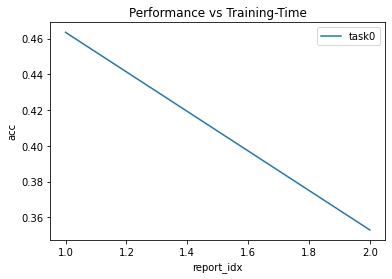

INFO:root:Training completed. Auto-saving to "AutogluonModels/ag-20210601_105826/". For loading the model, you can use `predictor = TextPredictor.load("AutogluonModels/ag-20210601_105826/")`


In [24]:
from autogluon.text import TextPredictor

predictor = TextPredictor(label='label', eval_metric='acc', )
predictor.fit(train,tuning_data=val)

In [25]:
val_score = predictor.evaluate(val)
print('Accuracy = {:.2f}%'.format(val_score * 100))

Accuracy = 39.30%


In [26]:
test_score = predictor.evaluate(test)
print('Accuracy = {:.2f}%'.format(test_score * 100))

Accuracy = 62.67%


In [27]:
from sklearn.metrics import classification_report
pred=predictor.predict(pd.DataFrame(val_text,columns=['text']))
print(classification_report(val_label,pred))

              precision    recall  f1-score   support

           0       0.73      0.11      0.19      2600
           1       0.36      0.93      0.52      1400

    accuracy                           0.39      4000
   macro avg       0.54      0.52      0.35      4000
weighted avg       0.60      0.39      0.30      4000



In [28]:
pred=predictor.predict(pd.DataFrame(test_text,columns=['text']))
print(classification_report(test_label,pred))

              precision    recall  f1-score   support

           0       0.59      0.14      0.22      1400
           1       0.63      0.94      0.75      2200

    accuracy                           0.63      3600
   macro avg       0.61      0.54      0.49      3600
weighted avg       0.61      0.63      0.55      3600



# validation

In [29]:
preds,trues=[],[]
for i in valx:
  pred=list(predictor.predict(pd.DataFrame(i.text,columns=['text'])))
  preds.append(max(pred,key=pred.count))
  trues.append(int(np.mean(i.label)))
print(classification_report(trues,preds))  

              precision    recall  f1-score   support

           0       0.80      0.31      0.44        13
           1       0.40      0.86      0.55         7

    accuracy                           0.50        20
   macro avg       0.60      0.58      0.49        20
weighted avg       0.66      0.50      0.48        20



In [ ]:
preds,trues=[],[]
for i in testx:
  pred=list(predictor.predict(pd.DataFrame(i.text,columns=['text'])))
  preds.append(max(pred,key=pred.count))
  trues.append(int(np.mean(i.label)))
print(classification_report(trues,preds))  

# test evaluation

In [ ]:
from glob import glob
test_path=pd.DataFrame(glob('test/en/*.xml'),columns=['id'])
test_path.head()

In [ ]:
test=reader(test_path,ground=False)

In [ ]:
test[0].head()

In [ ]:
final_preds=[]
for i in range(len(test)):
  test[i].text=preprocessing(test[i].text)
  pred=list(predictor.predict(test[i]))
  final_preds.append(max(pred,key=pred.count))


In [ ]:
len(final_preds),len(test_path)

In [ ]:
ids=test_path.id.apply(lambda x:x.split('/')[-1].split('.')[0])

In [ ]:
lang=['en']*len(test_path)

In [ ]:
final=pd.DataFrame(zip(ids,lang,final_preds),columns=['author-id','lang','type'])
final.head()